In [44]:
## sneaky imports and redefinitions
import networkx as nx
import matplotlib.pyplot as plt
import cpmpy as cp
import time
import copy
draw = nx.draw_circular

cmap = ["yellow", "cyan", "lightgreen"]
import re

from cpmpy.expressions.core import Comparison
def remove_edge(graph, constraint):
    graph = copy.deepcopy(graph)
    
    assert isinstance(constraint, Comparison)
    n1, n2 = constraint.args
    a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
    b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
    graph.remove_edge(a,b)
    return graph

def draw_conflict(graph, conflict, **kwargs):
    
    conflicting = []
    for cons in conflict:
        n1, n2 = cons.args
        if n1.name == "max": continue
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        conflicting.append((a,b))
        
    colors = ["red" if (a,b) in conflicting else "black" for (a,b) in graph.edges()]       
    return draw(graph, edge_color=colors, **kwargs)


import numpy as np

e = 0 # value for empty cells
given = np.array([
        [e, e, e,  2, e, 5,  e, e, e],
        [e, 9, e,  e, e, e,  7, 3, e],
        [e, e, 2,  e, e, 9,  e, 6, e],

        [2, e, e,  e, e, e,  4, e, 9],
        [e, e, e,  e, 7, e,  e, e, e],
        [6, e, 9,  e, e, e,  e, e, 1],

        [e, 8, e,  4, e, e,  1, e, e],
        [e, 6, 3,  e, e, e,  e, 8, e],
        [e, e, e,  6, e, 8,  e, e, e]])

from visualize import *

from cpmpy.transformations.normalize import toplevel_list
from factory import *
from read_data import get_data
    

def partition_csp(soft, hard=[]):
    
    soft = toplevel_list(soft, merge_and=False)
    ind = cp.boolvar(shape=len(soft))  # Boolean indicator variable for each constraint
    
    maxsat_model = cp.Model(ind.implies(soft))  # add reified constraints
    maxsat_model.maximize(cp.sum(ind))  # find largest MSS = smallest MCS
    maxsat_model += hard
    
    
    assert maxsat_model.solve()
    
    mss = [c for a,c in zip(ind, soft) if a.value() is True]
    mcs = [c for a,c in zip(ind, soft) if a.value() is False]
    
    return mss, mcs

## Applications of CP modelling

### Graph coloring

Given a graph $G(V,E)$ with vertices $V$ and edges $E$, a graph valid graph coloring assigsn a different color to each of the connected vertices.

In [2]:
def graph_coloring(G):
    m = cp.Model()
    max_colors = G.number_of_nodes()
    # dict of node-names to intvar
    nodes = cp.intvar(1, max_colors+1, shape=max_colors, name="Node")
    # constrain adges to have differently colored nodes
    m += [nodes[n1] != nodes[n2] for n1, n2 in G.edges()]
    m.minimize(cp.max(nodes))
    
    return m, nodes

Lets generate a random graph

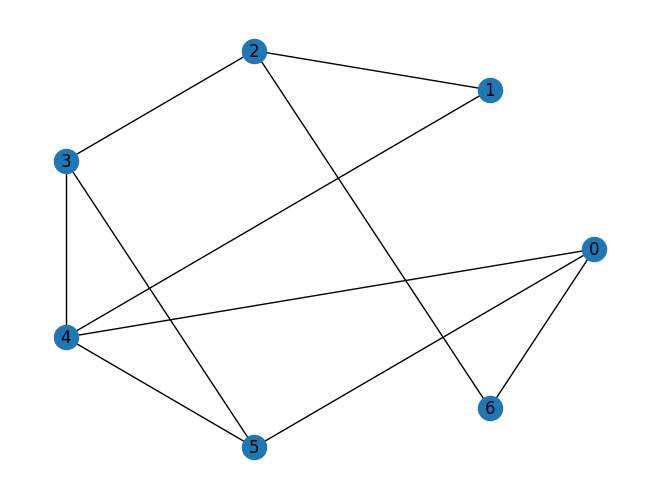

In [3]:
G = nx.fast_gnp_random_graph(7, 0.5, seed=0)
draw(G, with_labels=True)

In [4]:
# modela and variables
model, nodes = graph_coloring(G)

assert model.solve()

print(f"Number of colors: {model.objective_value()} -- {model.status()}")

Number of colors: 3 -- ExitStatus.OPTIMAL (0.002555 seconds)


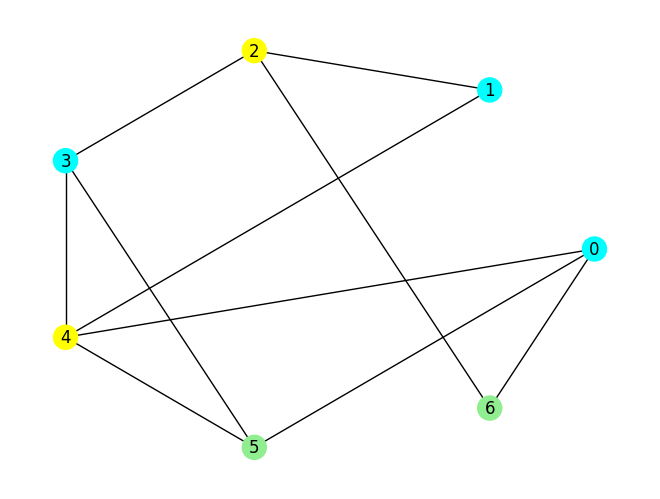

In [5]:
# and visualize it now with colors
color_map = [cmap[n.value()-1] for n in nodes]
draw(G, with_labels=True, node_color=color_map)

## Applications of CP modelling

<img src="img/sudoku_puzzle.png" width="45%" align="right" style="margin:50px;">

### Sudoku puzzle

Fill in empty cells such that:
- in each row all 9 numbers occur
- in each column all 9 numbers occur
- in each 9x9 block all numbers occur

Sudoku puzzle            |  Sudoku code
:-------------------------: |:-------------------------:
<img src="img/sudoku_code.png" width=60% align="center">| <img src="img/sudoku_puzzle.png" width="60%" align="center">
<!-- ![](img/sudoku_code.png)  |  ![](img/sudoku_puzzle.png) -->


In [6]:
import numpy as np

e = 0 # value for empty cells
given = np.array([
        [e, e, e,  2, e, 5,  e, e, e],
        [e, 9, e,  e, e, e,  7, 3, e],
        [e, e, 2,  e, e, 9,  e, 6, e],

        [2, e, e,  e, e, e,  4, e, 9],
        [e, e, e,  e, 7, e,  e, e, e],
        [6, e, 9,  e, e, e,  e, e, 1],

        [e, 8, e,  4, e, e,  1, e, e],
        [e, 6, 3,  e, e, e,  e, 8, e],
        [e, e, e,  6, e, 8,  e, e, e]])

In [7]:
def sudoku(given):
    
    cells = cp.intvar(1,9,shape=(9,9), name="cell") # decision variables
    
    m = cp.Model()
    m += [cp.AllDifferent(row) for row in cells]
    m += [cp.AllDifferent(col) for col in cells.T] # use numpy transpose
    for i in range(0,3,9):
        for j in range(0,3,9):
            m += cp.AllDifferent(cells[i:i+3, j:j+3])
    
    # given cells must be filled in
    m += cells[given != e] == given[given != e]
    
    return m, cells

In [8]:
model, cells = sudoku(given)

assert model.solve()

cells.value()

array([[8, 1, 7, 2, 6, 5, 9, 4, 3],
       [5, 9, 6, 1, 4, 2, 7, 3, 8],
       [4, 3, 2, 5, 1, 9, 8, 6, 7],
       [2, 5, 1, 8, 3, 6, 4, 7, 9],
       [1, 2, 8, 3, 7, 4, 6, 9, 5],
       [6, 4, 9, 7, 8, 3, 2, 5, 1],
       [3, 8, 5, 4, 9, 7, 1, 2, 6],
       [7, 6, 3, 9, 2, 1, 5, 8, 4],
       [9, 7, 4, 6, 5, 8, 3, 1, 2]])

## Applications of CP

### Nurse rostering

<img src="img/nurse_rost_prob.jpg">

* The assignment of _shifts_ and _holidays_ to nurses.
* Each nurse has their own restrictions and preferences,
    as does the hospital.


## Nurse Rostering: constraints 1/2

### hospital constraints/preferences:

<img src="img/nurse_rost_prob.jpg" align="right">

* nb of nurses assigned
* max nb of shifts
* max nb of weekend shifts
* min nb of (consecutive) days off
* min/max minutes worked
* min/max consecutive shifts
* shift rotation

## Nurse Rostering: constraints 2/2

### nurse constraints/preferences:

<img src="img/nurse_rost_prob.jpg" align="right">

* specific days off-duty
* specific shift requests (on/off)


## Nurse rostering: data

In [9]:
#instance = "http://www.schedulingbenchmarks.org/nrp/data/Instance1.txt"
instance = "Benchmarks/Instance1.txt"
data = get_data(instance)

# all data is stored as DataFrame tables
data.staff

,# ID,MaxShifts,MaxTotalMinutes,MinTotalMinutes,MaxConsecutiveShifts,MinConsecutiveShifts,MinConsecutiveDaysOff,MaxWeekends,D,name
0,A,D=14,4320,3360,5,2,2,1,14,Megan
1,B,D=14,4320,3360,5,2,2,1,14,Katherine
2,C,D=14,4320,3360,5,2,2,1,14,Robert
3,D,D=14,4320,3360,5,2,2,1,14,Jonathan
4,E,D=14,4320,3360,5,2,2,1,14,William
5,F,D=14,4320,3360,5,2,2,1,14,Richard
6,G,D=14,4320,3360,5,2,2,1,14,Kristen
7,H,D=14,4320,3360,5,2,2,1,14,Kevin


Lets encode this in CPMpy!


Specific days off-duty

In [10]:
factory = NurseSchedulingFactory(data)
model, nurse_view = factory.get_full_model()

In [11]:
for (empl_id, row) in data.days_off.iterrows():
    empl_idx = data.staff.index[data.staff["# ID"] == empl_id][0]
    day_idx = row["DayIdx"]
    
    con = (nurse_view[empl_idx, day_idx] == 0)
    
    con.set_description(f"{data.staff.iloc[empl_idx]['name']} should not work on day {day_idx}")
    print("-",con)

- Megan should not work on day 0
- Katherine should not work on day 5
- Robert should not work on day 8
- Jonathan should not work on day 2
- William should not work on day 9
- Richard should not work on day 5
- Kristen should not work on day 1
- Kevin should not work on day 7


In [12]:
model.solve()

True

In [13]:
visualize(nurse_view.value(), factory)

# Explainable constraint solving

## Model + Solve

<center><img src="img/model_solve.png" width=70%></center>

- What if the model is UNSAT?
- What if the solution is unexpected?
- What if the user wants to change something?

--> Trustworthy & Explainable AI

## Trustworthy & Explainable constraint solving

Human-aware AI:

- Respect human _agency_
- _Support_ users in decision making
- Provide explanations and learning opportunities

Acknowledges that a 'model' is only an approximation,<br />
that it might result in _undesirable_ solutions.

### Explainable AI (XAI), brief highlights

#### D. Gunning, 2015: DARPA XAI challenge
"Every explanation is set within a context that depends..." <!-- on the task, abilities, and expectations of the user of the AI system." --> -> domain dependent

#### M. Fox et al, 2017: Explainable Planning

Need for trust, interaction and transparancy.

#### T. Miller, 2018: Explainable AI: Beware of Inmates Running the Asylum

Insights from the social sciences: _Someone_ explains _something_ to _someone_

#### R. Guidotti, 2018: A survey of methods for explaining black box ML models

The vast majority of work/attention...

## Explainable Constraint Programming (XCP)

In general, "**Why X?**" &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (with X a solution or UNSAT)

To be defined... 3 patterns:
- Causal explanation:
  - _How was X derived?_
- Contrastive explanation:
  - _Why X and not Z?_
- Conversational explanation:
  - _Iteratively refine explanation & model_


## Hands-on Explainable Constraint Programming (XCP)


<img src="img/interaction_figure4.png" width="20%" align="right" style="margin:50px;">

- The model: Nurse Rostering
- The system: CPMpy modeling library
- **Explain UNSAT**:
  - **Causal explanations (MUS, OUS)**
  - Conversational explanations

In [14]:
# model as decision model
factory = NurseSchedulingFactory(data)
model, nurse_view = factory.get_decision_model()  # CMPpy DECISION Model
model.solve()

False

... no solution found

In [15]:
constraints = toplevel_list(model.constraints, merge_and=False) # normalization for later
print(f"Model has {len(constraints)} constraints:")
for cons in constraints: print("-", cons)

Model has 168 constraints:
- Megan cannot work more than 14 shifts of type 1
- Katherine cannot work more than 14 shifts of type 1
- Robert cannot work more than 14 shifts of type 1
- Jonathan cannot work more than 14 shifts of type 1
- William cannot work more than 14 shifts of type 1
- Richard cannot work more than 14 shifts of type 1
- Kristen cannot work more than 14 shifts of type 1
- Kevin cannot work more than 14 shifts of type 1
- Megan cannot work more than 4320min
- Katherine cannot work more than 4320min
- Robert cannot work more than 4320min
- Jonathan cannot work more than 4320min
- William cannot work more than 4320min
- Richard cannot work more than 4320min
- Kristen cannot work more than 4320min
- Kevin cannot work more than 4320min
- Megan cannot work more than 3360min
- Katherine cannot work more than 3360min
- Robert cannot work more than 3360min
- Jonathan cannot work more than 3360min
- William cannot work more than 3360min
- Richard cannot work more than 3360min
-

<img src="img/mus.png" width="20%" align="left" style="margin:50px;">

Trim model to minimal set of constraints

... minimize cognitive burden for user


### How to compute a MUS?

CPMpy implements a deletion-based MUS algorithm,using assumption variables

* `cpmpy.tools.mus`

In [16]:
from cpmpy.tools.mus import mus

solver = "ortools"
subset = mus(model.constraints, solver=solver) 

print("Length of MUS:", len(subset))
for cons in subset: print("-", cons)

Length of MUS: 11
- Kevin requests to work shift D on Sun 2
- Robert requests to work shift D on Fri 1
- Robert requests to work shift D on Thu 1
- Robert requests to work shift D on Wed 1
- Robert requests to work shift D on Tue 1
- Robert requests to work shift D on Mon 1
- Richard has a day off on Sat 1
- Katherine has a day off on Sat 1
- Kevin should work at most 1 weekends
- Robert can work at most 5 days before having a day off
- Shift D on Sat 1 must be covered by 5 nurses out of 8


In [17]:
visualize_constraints(subset, nurse_view, factory)

### Many MUS'es may exist...

_Liffiton, M.H., & Malik, A. (2013). Enumerating infeasibility: Finding multiple MUSes quickly. In
Proceedings of the 10th International Conference on Integration of AI and OR Techniques in Constraint
    Programming (CPAIOR 2013) (pp. 160–175)_

In [18]:
# MARCO MUS/MSS enumeration
from explanations.marco_mcs_mus import do_marco
solver = "ortools"  # default solver
if "exact" in cp.SolverLookup.solvernames(): solver = "exact"  # fast for increment solving
    
t0 = time.time()
cnt = 0
for (kind, sset) in do_marco(model, solver=solver):
    if kind == "MUS":
        print("M", end="")
        cnt += 1
    else: print(".", end="") # MSS
    
    if time.time() - t0 > 20:  break  # for tutorial: break after 20s
print(f"\nFound {cnt} MUSes in", time.time() - t0)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-09
MMM.....M....
Found 4 MUSes in 20.368577003479004


### Many MUS'es may exist...

<img src="img/musses.png" width="40%" align="left" style="margin-left:50px; margin-right:50px">

This problem has just 168 constraints, yet 100.000+ MUSes exist...

Which one to show? 

In explanations less is more, so lets find the **smallest one directly!**

> Ignatiev, Alexey, et al. "Smallest MUS extraction with minimal hitting set dualization." International Conference on Principles and Practice of Constraint Programming. Cham: Springer International Publishing, 2015.

In [19]:
from explanations.subset import smus

small_subset = smus(model.constraints, solver="ortools", hs_solver="gurobi")

print("Length of sMUS:", len(small_subset))
for cons in small_subset:  
    print("-", cons)

Length of sMUS: 3
- Robert has a day off on Tue 2
- Richard requests to not work shift D on Tue 2
- Shift D on Tue 2 must be covered by 7 nurses out of 8


In [20]:
visualize_constraints(small_subset, nurse_view, factory)

<img src="img/nowwhat.gif" width="40%" align="right" style="margin-left:50px; margin-right:50px">

... We found a conflict!

Now what?

Let's correct it!

How? 

First idea: remove one of the constraints in the conflict

Let's illustrate with graph coloring example

In [36]:
graph_model, nodes = graph_coloring(G)
graph_model.solve()

True

In [37]:
from explanations.subset import smus

graph_model += cp.max(nodes) < 3
graph_model.solve()

False

In [38]:
conflict = smus(graph_model.constraints)
for cons in conflict:
    print("-", cons)

- (Node[3]) != (Node[4])
- (Node[3]) != (Node[5])
- (Node[4]) != (Node[5])
- max(Node[0],Node[1],Node[2],Node[3],Node[4],Node[5],Node[6]) < 3


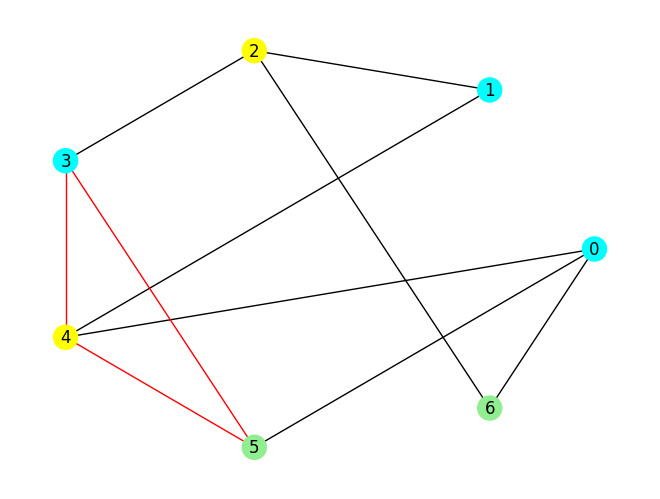

In [39]:
draw_conflict(G,conflict, node_color=color_map, with_labels=True)

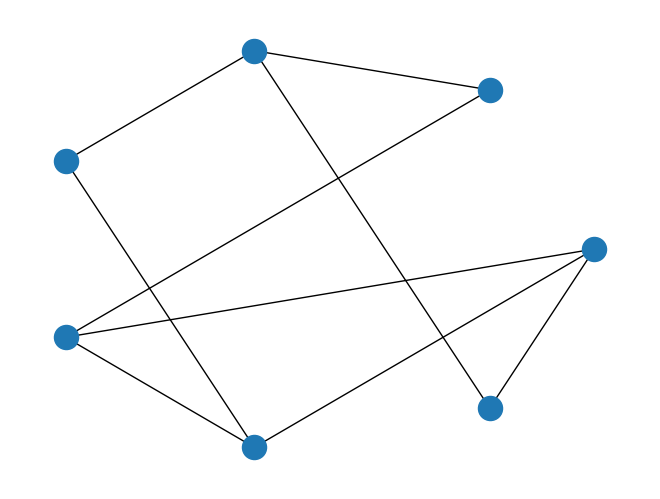

In [40]:
new_G = remove_edge(G, conflict[0])
draw(new_G)

In [41]:
new_model, nodes = graph_coloring(new_G)
new_model += cp.max(nodes) < 3
new_model.solve()

False

... still UNSAT

Remember, MANY conflics may exist...

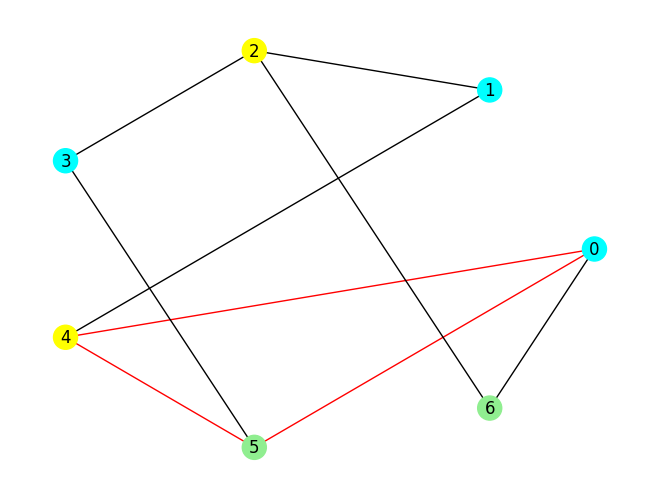

In [42]:
conflict = smus(new_model.constraints, solver="ortools", hs_solver="gurobi")
draw_conflict(new_G,conflict, node_color=color_map, with_labels=True)

...rinse and repeat?

**NO**

## Fixing UNSAT Models


<img src="img/fixing_mcs.png" width="20%" align="left" style="margin:50px;">

How to **change the model**, in order to find a solution?

find subset of _soft constraints_ to keep <br> 
= <br>
find constraints to be **removed**, e.g. remove a correction subset! 

### Fixing UNSAT Models

<img src="img/mcs.png" width="20%" align="left" style="margin:50px;">

Find maximal satisfiable subset (MSS) and take complement

[(Node[2]) != (Node[6]), (Node[4]) != (Node[5])]


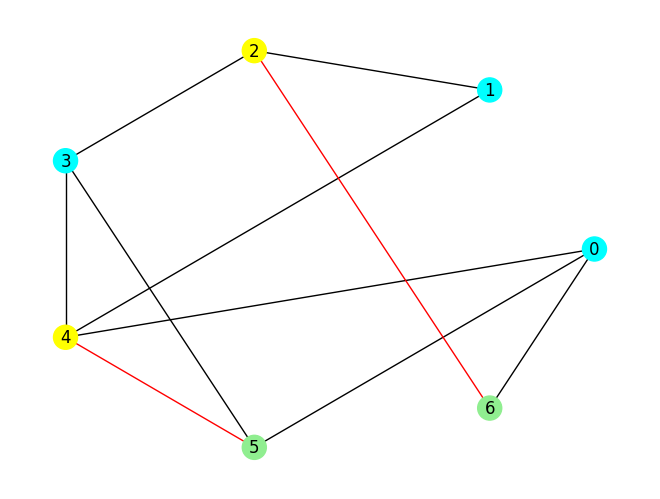

In [53]:
from explanations.subset import mcs  # using assumption variables
constraints = list(reversed(graph_model.constraints))

corr_subset = mcs(constraints)

print(corr_subset)
draw_conflict(G,corr_subset, node_color=color_map, with_labels=True)

## Fixing UNSAT models - Nurse rostering

In [54]:
# model as decision model
factory = NurseSchedulingFactory(data)
model, nurse_view = factory.get_decision_model()  # CMPpy DECISION Model
model.solve()

False

In [56]:
corr_subset = mcs(model.constraints)

print("By removing these constraints, the model becomes SAT:")
for cons in corr_subset: print("-",cons)
    
visualize_constraints(corr_subset, nurse_view, factory)

By removing these constraints, the model becomes SAT:
- Shift D on Tue 2 must be covered by 7 nurses out of 8
- Shift D on Sun 1 must be covered by 5 nurses out of 8
- Shift D on Sat 1 must be covered by 5 nurses out of 8
- Shift D on Mon 2 must be covered by 6 nurses out of 8
- Shift D on Thu 2 must be covered by 2 nurses out of 8


In [57]:
mss = set(toplevel_list(model.constraints, merge_and=False)) - set(corr_subset)
        
corrected_model = cp.Model(list(mss))
assert corrected_model.solve()

visualize(nurse_view.value(), factory)

## Fixing UNSAT Models

_Removing_ constraints from the model is drastic...

In the previous solution, no nurses on Sunday? What if you break your leg that day?

<br>

<img src="img/fixing_mcs.png" width="20%" align="right" style="margin:50px;">

Second idea:

Slightly **violate** constraints which allows for **relaxation** of constraints

E.g. **feasbility restoration** by modifying rather then removing constraints

### Relaxation of constraints

<img src="img/slack.png" width="20%" align="left" style="margin:20px;">

* Boolean constraints can only be turned on/off
* Numerical constraints can be __violated__ to some extend
* Introduce slack for each numerical constraint
* Slack indicates how much a constraint may be violated
   - = fine grained penalty of solution!
* Minimize aggregate of slack values

> Senthooran I, Klapperstueck M, Belov G, Czauderna T, Leo K, Wallace M, Wybrow M, Garcia de la Banda M. Human-centred feasibility restoration in practice. Constraints. 2023 Jul 20:1-41.

### Relaxation of constraints

<img src="img/slack.png" width="20%" align="left" style="margin:20px;">

E.g., allow violation of _cover constraints_ <br>
    --> Allow shifts to be slightly under/overstaffed

In [60]:
slack_model, slack_nurse_view, slack_under, slack_over = factory.get_slack_model()  # CMPpy Model

for _, cover in factory.data.cover.iterrows():
    # read the data
    day = cover["# Day"]
    shift = factory.shift_name_to_idx[cover["ShiftID"]]
    requirement = cover["Requirement"]
    
    nb_nurses = cp.Count(nurse_view[:, day], shift)
    expr = nb_nurses == requirement - slack_under[day] + slack_over[day]

#### Minimize global violation